# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
# Check the present working directory
!pwd

/Users/chrismo/Documents/UdaCSP



### Important Note
>Delete the **data/** folder and the downloaded tar file, before you submit your code. The current workspace cannot save the files beyond 1GB of space in total. 


### Import the Packages

In [6]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import re
from scipy import stats


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from collections import Counter


from yellowbrick.cluster import KElbowVisualizer

# Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

>Note: If you experience "Kernel died" issue while running the codeblock below, then load less number of rows from the .csv files.

# Part 1. Preprocessing

In [110]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

/var/folders/y1/2cln1s193dgc6xy3yzry761r0000gn/T/ipykernel_12687/374577498.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')


In [138]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [140]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [142]:
print(f'The General dataset has {azdias.shape[0]} rows and {azdias.shape[1]} columns')
print(f'The Customers dataset has {customers.shape[0]} rows and {customers.shape[1]} columns')

The General dataset has 891221 rows and 366 columns
The Customers dataset has 191652 rows and 369 columns


In [144]:
customer_list = list(customers.keys())
general_list = list(azdias.keys())

In [148]:
np.setdiff1d(customer_list, general_list)

array(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype='<U27')

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## Preprocessing General Population Data - AZDIAS

In [ ]:
azdias.isna().sum().sort_values(ascending=False).head(30)

In [ ]:
(azdias.isna().sum()/azdias.shape[0]*100).sort_values(ascending=False).head(50)

Having data above 50% missing calls for further investigation

In [ ]:
missing_sorted = (azdias.isna().sum()/azdias.shape[0]*100).sort_values(ascending=False).head(50)  #missing values in oly the top 50 columns

In [ ]:
plt.figure(figsize=(12, 9))
plt.bar(missing_sorted.index, missing_sorted.values)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('% Missing')
plt.title('Missing Value Plot for top 50 columns')
;

We have opted not to delete dimensions greater than 20% of them lost, This is simply because they contain banking data. This can easily be a huge factor for us really

In [ ]:
high_missing_list = ['ALTER_KIND4','ALTER_KIND3','ALTER_KIND2','ALTER_KIND1','EXTSEL992','KK_KUNDENTYP']

In [ ]:
for col in high_missing_list:
    print(azdias[col].value_counts())
    print("-------")

Sidenote: The columns in `high_missing_list` were examined in the dictionary provided, and no result was found for any of them

In [ ]:
print(f'Total data shape is {azdias.shape[0]}')
azdias.nunique().sort_values(ascending=False).head(30)

In [ ]:
azdias['LNR'].value_counts()

Having a column with such high dimensionality would definitely be hurtful for our entire analysis, we have to drop it 

In [ ]:
high_dimensionality_list = ['LNR']

In [ ]:
valueless_columns = []

for col in azdias.columns:
    try:
        azdias[col].plot(kind='hist')
        plt.title(f'Box plot for {col}')
        plt.show()
    except TypeError:
        valueless_columns.append(col)
        continue

#### Seeing the Histograms we investigate the two columns `D19_TELKO_ONLINE_QUOTE_12` and `D19_VERSI_ONLINE_QUOTE_12` further

In [ ]:
azdias['D19_TELKO_ONLINE_QUOTE_12'].value_counts()

In [ ]:
azdias['D19_VERSI_ONLINE_QUOTE_12'].value_counts()

In [ ]:
azdias['D19_VERSI_ONLINE_QUOTE_12'].plot(kind='hist')

In [ ]:
azdias['D19_TELKO_ONLINE_QUOTE_12'].plot(kind='hist')

In [ ]:
valueless_columns

In [ ]:
for col in valueless_columns:
    print(azdias[col].unique().tolist())
    print('------------------------------------------------')
    print(f'These are the values in the "{col}" column\n\n\n')

In [ ]:
azdias['EINGEFUEGT_AM'].nunique()

From understanding our excel sheet `DIAS ATTRIBUTE - Values 2017`, we can make these estimations:

`CAMEO_DEU_2015`: The XX, n values should be treated as nulls, while the alphabets behind the column values dropped

`CAMEO_DEUG_2015`: X, n values as nulls and convert the rests to float

`CAMEO_INTL_2015`: Conversion to type float

`D19_LETZTER_KAUF_BRANCHE`: Contains other Informative columns but they have a very inconsistent format so we drop them

`EINGEFUEGT_AM`: To be converted to datetime, feature engineering would follow from there

`OST_WEST_KZ`: 'n' columns as nulls, encoding the other 2 values

In [ ]:
azdias['CAMEO_DEUG_2015'].unique()

In [ ]:
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace({'X':np.nan, 'XX':np.nan, 'n':-1})

In [ ]:
azdias['CAMEO_DEUG_2015'].unique()

In [ ]:
azdias['ALTER_HH'].value_counts()

In [ ]:
azdias['D19_BANKEN_DIREKT'].value_counts()

In [ ]:
azdias.keys().to_list()

In [ ]:
cameo_mapping = {
    "1A": "Work-Life-Balance",
    "1B": "Wealthy Best Ager",
    "1C": "Successful Songwriter",
    "1D": "Old Nobility",
    "1E": "City Nobility",
    "2A": "Cottage Chic",
    "2B": "Noble Jogger",
    "2C": "Established Gourmet",
    "2D": "Fine Management",
    "3A": "Career & Family",
    "3B": "Powershopping Families",
    "3C": "Rural Neighborhood",
    "3D": "Secure Retirement",
    "4A": "Family Starter",
    "4B": "Family Life",
    "4C": "String Trimmer",
    "4D": "Empty Nest",
    "4E": "Golden Age",
    "5A": "Younger Employees",
    "5B": "Suddenly Family",
    "5C": "Family First",
    "5D": "Stock Market Junkies",
    "5E": "Coffee Rider",
    "5F": "Active Retirement",
    "6A": "Jobstarter",
    "6B": "Petty Bourgeois",
    "6C": "Long-established",
    "6D": "Sportgardener",
    "6E": "Urban Parents",
    "6F": "Frugal Aging",
    "7A": "Journeyman",
    "7B": "Mantaplatte",
    "7C": "Factory Worker",
    "7D": "Rear Window",
    "7E": "Interested Retirees",
    "8A": "Multi-cultural",
    "8B": "Young & Mobile",
    "8C": "Prefab",
    "8D":  "Town Seniors",
    "9A": "First Shared Apartment",
    "9B": "Temporary Workers",
    "9C": "Afternoon Talk Show",
    "9D": "Mini-Jobber",
    "9E": "Socking Away"}
    
    

In [ ]:
# Map the codes to descriptions
azdias['CAMEO_Description'] = azdias['CAMEO_DEU_2015'].map(cameo_mapping)

# Encode the resulting descriptions using one-hot encoding
encoded_df = pd.get_dummies(azdias['CAMEO_Description'], prefix='CAMEO')

# Combine with the original DataFrame
final_df = pd.concat([azdias, encoded_df], axis=1)

In [ ]:
assert valueless_columns == azdias.select_dtypes(include='object').keys().to_list()

In [9]:
feat_info = pd.read_csv('feature_info.csv')

In [11]:
feat_info.head()

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,AGER_TYP,best-ager typology,-1,unknown
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
2,ALTER_HH,main age within the household,0,unknown / no main age detectable
3,ANREDE_KZ,gender,"-1, 0",unknown
4,BALLRAUM,distance to next urban centre,-1,unknown


Dropping and cleaning feat_info dataframe

In [14]:
feat_info.columns

Index(['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [16]:
feat_info.drop(columns=['Unnamed: 2', 'Unnamed: 4'], inplace=True)

In [18]:
feat_info.rename(columns={'Unnamed: 1':'Attributes', 'Unnamed: 3':'Values'}, inplace=True)

In [20]:
feat_info

,Attributes,Values
0,AGER_TYP,-1
1,ALTERSKATEGORIE_GROB,"-1, 0"
2,ALTER_HH,0
3,ANREDE_KZ,"-1, 0"
4,BALLRAUM,-1
...,...,...
226,WACHSTUMSGEBIET_NB,"-1, 0"
227,WOHNDAUER_2008,"-1, 0"
228,WOHNLAGE,-1
229,W_KEIT_KIND_HH,"-1, 0"


We therefore use feat_info to clean out our Azdias dataframe

In [23]:
#feat_info = reference_df
#original_df = azdias_df

def encode_nan(original_df, reference_df):
    # Extract column names and corresponding values to be encoded as NaN
    unique_columns = reference_df['Attributes'].tolist()
    corresponding_values = reference_df['Values'].tolist()
    
    # Iterate over each column and value pair
    for col, value in zip(unique_columns, corresponding_values):
        if col in original_df.columns:
            # Replace specified values with NaN
            original_df.loc[original_df[col] == value, col] = np.nan
    return original_df

In [ ]:
dd = encode_nan(azdias, feat_info)

In [ ]:
dd.isna().sum().sum()

In [ ]:
dd['ALTERSKATEGORIE_GROB'].value_counts()

#### Feature Engineering the `EINGEFUEGT_AM` column

In [ ]:
azdias['EINGEFUEGT_AM'] = pd.to_datetime(azdias['EINGEFUEGT_AM'])
azdias['year'] = azdias['EINGEFUEGT_AM'].dt.year
azdias['month'] = azdias['EINGEFUEGT_AM'].dt.month
azdias['day_of_week'] = azdias['EINGEFUEGT_AM'].dt.weekday

##### Summary: From above code we understand this is all the wrangling needed for our Categorical columns

## General Cleaning Function

In [27]:
feat_info.head()

,Attributes,Values
0,AGER_TYP,-1
1,ALTERSKATEGORIE_GROB,"-1, 0"
2,ALTER_HH,0
3,ANREDE_KZ,"-1, 0"
4,BALLRAUM,-1


In [29]:
def clean_data(df: pd.DataFrame, reference_df: pd.DataFrame=feat_info) -> pd.DataFrame:
    """
    Cleans the entire dataframe based on specified criteria.
    
    Args: 
        df (pd.DataFrame) - dataframe for wrangling
        reference_df (pd.DataFrame) - reference dataframe for decoding 
        
    Return: df (pd.DataFrame) - cleaned dataframe
    """
    # Replace specific values with NaN
    df = df.replace({'X': np.nan, 'XX': np.nan, 'n': np.nan})

    def encode_nan(original_df, reference_df):
        # Extract column names and corresponding values to be encoded as NaN
        unique_columns = reference_df['Attributes'].tolist()
        corresponding_values = reference_df['Values'].tolist()
        
        # Iterate over each column and value pair
        for col, values in zip(unique_columns, corresponding_values):
            if col in original_df.columns:
                # Split multiple values and replace each with NaN
                for value in str(values).split(','):
                    original_df.loc[original_df[col] == int(value.strip()), col] = np.nan
        return original_df
    
    # Apply encoding function
    df = encode_nan(df, reference_df)

    # Process date column
    if 'EINGEFUEGT_AM' in df.columns:
        df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'])
        df['year'] = df['EINGEFUEGT_AM'].dt.year
        df['month'] = df['EINGEFUEGT_AM'].dt.month
        df['day_of_week'] = df['EINGEFUEGT_AM'].dt.dayofweek

    # Drop specified columns
    columns_to_drop = ['ALTER_KIND4', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 
                       'EXTSEL992', 'KK_KUNDENTYP', 'D19_LETZTER_KAUF_BRANCHE', 
                       'LNR', 'EINGEFUEGT_AM', 'D19_TELKO_ONLINE_QUOTE_12', 
                       'D19_VERSI_ONLINE_QUOTE_12']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Encode OST_WEST_KZ
    if 'OST_WEST_KZ' in df.columns:
        df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    
    # Map CAMEO_DEU_2015 to descriptions
    cameo_mapping = {
        "1A": "Work-Life-Balance", "1B": "Wealthy Best Ager", "1C": "Successful Songwriter",
        "1D": "Old Nobility", "1E": "City Nobility", "2A": "Cottage Chic",
        "2B": "Noble Jogger", "2C": "Established Gourmet", "2D": "Fine Management",
        "3A": "Career & Family", "3B": "Powershopping Families", "3C": "Rural Neighborhood",
        "3D": "Secure Retirement", "4A": "Family Starter", "4B": "Family Life",
        "4C": "String Trimmer", "4D": "Empty Nest", "4E": "Golden Age",
        "5A": "Younger Employees", "5B": "Suddenly Family", "5C": "Family First",
        "5D": "Stock Market Junkies", "5E": "Coffee Rider", "5F": "Active Retirement",
        "6A": "Jobstarter", "6B": "Petty Bourgeois", "6C": "Long-established",
        "6D": "Sportgardener", 
	"6E":"Urban Parents","6F":"Frugal Aging","7A":"Journeyman","7B":"Mantaplatte",
	"7C":"Factory Worker","7D":"Rear Window","7E":"Interested Retirees",
	"8A":"Multi-cultural","8B":"Young & Mobile","8C":"Prefab","8D":"Town Seniors",
	"9A":"First Shared Apartment","9B":"Temporary Workers","9C":"Afternoon Talk Show",
	"9D":"Mini-Jobber","9E":"Socking Away"
    }
    
    if 'CAMEO_DEU_2015' in df.columns:
        df['CAMEO_Description'] = df['CAMEO_DEU_2015'].map(cameo_mapping)
        df = df.drop(columns=['CAMEO_DEU_2015'])
    
    # One-hot encode CAMEO_Description
    if 'CAMEO_Description' in df.columns:
	    df = pd.get_dummies(df, columns=['CAMEO_Description'], prefix='CAMEO')

    # Impute missing values
    for column in df.columns:
        if df[column].dtype == 'object':
            mode_value = df[column].mode()[0] if not df[column].mode().empty else ''
            df[column] = df[column].fillna(mode_value)
        else:
            median_value = df[column].median() if not np.isnan(df[column].median()) else 0
            df[column] = df[column].fillna(median_value)

    df = df.astype('int')
    
    return df


In [31]:
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')

/var/folders/y1/2cln1s193dgc6xy3yzry761r0000gn/T/ipykernel_12687/4216581686.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')


In [33]:
df = clean_data(azdias)

In [35]:
df.isna().sum().sum()

0

In [37]:
df.shape[0]

891221

In [39]:
df.select_dtypes(include='object').keys()   #confirming we have no OBJECT columns left

Index([], dtype='object')

# Part 2. Feature Transformation

Looking at every value counts we have using the histogram plotted earlier, we see a wide wide range of distributed values. For this reason, we have to scale each column wrt. its standard deviation

In [41]:
df.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_String Trimmer,CAMEO_Successful Songwriter,CAMEO_Suddenly Family,CAMEO_Temporary Workers,CAMEO_Town Seniors,CAMEO_Urban Parents,CAMEO_Wealthy Best Ager,CAMEO_Work-Life-Balance,CAMEO_Young & Mobile,CAMEO_Younger Employees
0,2,3,16,14,4,0,0,1,3,0,...,0,0,0,0,0,0,0,0,0,0
1,2,9,16,21,11,0,0,2,12,0,...,0,0,0,0,0,0,0,0,0,0
2,2,9,17,17,10,0,0,1,7,0,...,1,0,0,0,0,0,0,0,0,0
3,2,1,13,13,1,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,20,14,3,0,0,4,3,0,...,0,0,0,0,0,0,0,0,0,0


In [332]:
scaler = StandardScaler()    #making scaler instance

In [334]:
scaled_data = scaler.fit_transform(df)

In [336]:
scaled_dataframe = pd.DataFrame(scaled_data, columns = df.columns)
scaled_dataframe         #sample scaling we would do in our dataframe

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_String Trimmer,CAMEO_Successful Songwriter,CAMEO_Suddenly Family,CAMEO_Temporary Workers,CAMEO_Town Seniors,CAMEO_Urban Parents,CAMEO_Wealthy Best Ager,CAMEO_Work-Life-Balance,CAMEO_Young & Mobile,CAMEO_Younger Employees
0,0.200115,-0.371973,0.149547,0.049442,-0.258584,-0.118316,-0.292527,-0.593390,-0.302057,-0.057885,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
1,0.200115,1.338692,0.149547,1.689818,0.212895,-0.118316,-0.292527,0.295412,0.357993,-0.057885,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
2,0.200115,1.338692,0.473490,0.752460,0.145541,-0.118316,-0.292527,-0.593390,-0.008701,-0.057885,...,4.199688,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
3,0.200115,-0.942195,-0.822281,-0.184898,-0.460647,-0.118316,-0.292527,-1.482193,-0.375395,-0.057885,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
4,0.200115,-0.942195,1.445318,0.049442,-0.325938,-0.118316,-0.292527,2.073018,-0.302057,-0.057885,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,0.200115,0.198249,0.473490,0.752460,0.482312,-0.118316,-0.292527,-0.593390,0.284654,-0.057885,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
891217,0.200115,1.338692,0.149547,0.518120,0.212895,-0.118316,-0.292527,-0.593390,0.284654,-0.057885,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
891218,0.200115,-0.942195,0.473490,0.752460,-0.325938,-0.118316,-0.292527,-1.482193,-0.302057,-0.057885,...,4.199688,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878
891219,0.200115,1.338692,0.149547,1.455478,-0.056522,-0.118316,1.777488,-0.593390,-0.155379,-0.057885,...,-0.238113,-0.069767,-0.108417,-0.179023,-0.141838,-0.135667,-0.067741,-0.111015,-0.197426,-0.117878


In [43]:
def apply_pca(x:int=None, df:pd.DataFrame=df):
    """
    INPUT:
    x: str denoting number of components to be broken down into
    df: scaled dataframe to find principal components
    OUTPUT:
    df_pca: (np.array) denoting result
    pca: object denoting PCA's instantiation
    """
    scaler = StandardScaler()    #including scaling in function for ease
    scaled_data = scaler.fit_transform(df)
    pca = PCA(n_components=x, random_state = 42)       #ensuring reproducability
    df_pca = pca.fit_transform(scaled_data)
    return pca, df_pca

In [45]:
pca, df_pca = apply_pca()         #base pca with 0 components

In [46]:
pca

PCA(random_state=42)

In [47]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 11))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance-Explained Ratio")
    plt.title('Explained Variance Per Principal Component')

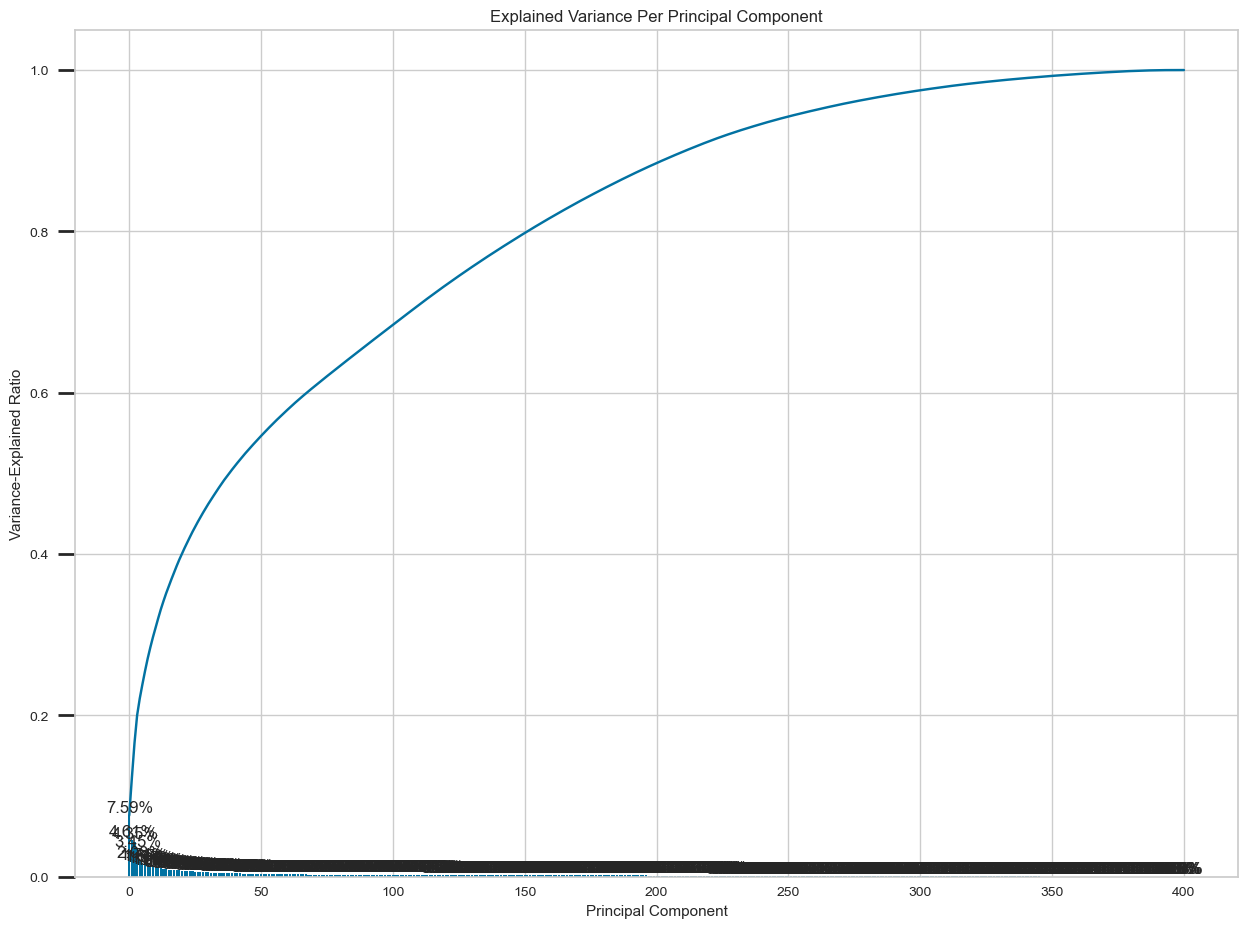

In [48]:
scree_plot(pca)

In [53]:
def pca_results(full_dataset:pd.DataFrame, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = ['Dimension {}'.format(x) for x in range(1,len(pca.components_)+1)]

	# PCA components as a dataframe on their own
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance as another dataframe
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (15,10))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

In [55]:
ls

Arvato Project Workbook.ipynb* excelfiles/
Untitled.ipynb                 feature_info.csv
data/                          hehe.csv
dmail.csv


### Here, we choose to perform out PCA upto a 90% explained variability as explained in this [post](https://www.linkedin.com/advice/3/how-can-you-determine-optimal-number-principal-4opaf)

Setting a 90% cumulative explained variance threshold compresses our data, retaining most of the original information while significantly reducing the number of features/columns. This balances dimensionality reduction with preserving key data patterns

Note: This threshold is always set by business product managers / stakeholders

In [59]:
df.shape

(891221, 401)

From scree plot, we see `215` components are just about right

In [62]:
df.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_String Trimmer,CAMEO_Successful Songwriter,CAMEO_Suddenly Family,CAMEO_Temporary Workers,CAMEO_Town Seniors,CAMEO_Urban Parents,CAMEO_Wealthy Best Ager,CAMEO_Work-Life-Balance,CAMEO_Young & Mobile,CAMEO_Younger Employees
0,2,3,16,14,4,0,0,1,3,0,...,0,0,0,0,0,0,0,0,0,0
1,2,9,16,21,11,0,0,2,12,0,...,0,0,0,0,0,0,0,0,0,0
2,2,9,17,17,10,0,0,1,7,0,...,1,0,0,0,0,0,0,0,0,0
3,2,1,13,13,1,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,20,14,3,0,0,4,3,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
pca, df_pca = apply_pca(215, df)

In [65]:
pca

PCA(n_components=215, random_state=42)

0.9041


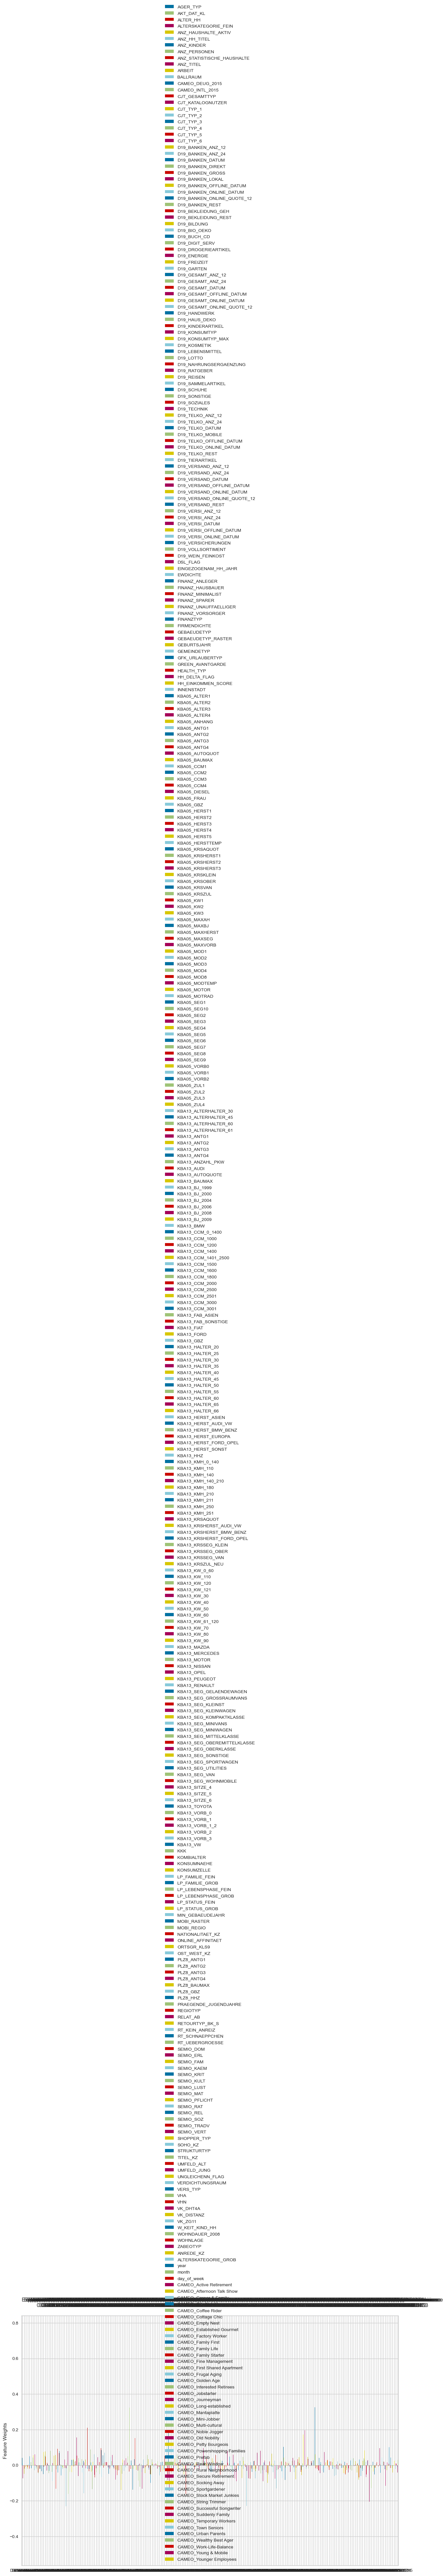

In [73]:
print(pca_results(df, pca)['Explained Variance'].sum());            #investigating variance for each threshold

In [74]:
def weights(n:int, pca, df:pd.DataFrame) -> pd.DataFrame:
    """
    INPUT: 
    n(int): index ot principal component to analyze
    pca(sklearn.decomposition.PCA): a PCA fitted object containing eigen vectors
    df(pd.DataFrame): a dataframe to examine weights

    OUTPUT: 
    df(pd.DataFrame): result dataframe having columns as index, and corresponding weights
    """
    
    col_list = list(df.keys())
    weight=list(pca.components_[n])
    
    df =pd.DataFrame(list(zip(col_list, weight)))
    df = df.set_axis(['Dimension', 'Weights'], axis=1)
    df = df.sort_values(by=['Weights'] , ascending=False)
    df.set_index('Dimension', inplace=True)
    
    return df

In [75]:
final_comp = weights(214, pca, df)          #214 because pca_components_ are zero indexed

In [63]:
final_comp

,Weights
Dimension,
KBA13_HALTER_65,0.243417
ANZ_HH_TITEL,0.234111
KBA13_HALTER_20,0.199847
KBA13_SITZE_6,0.198575
KBA05_DIESEL,0.182045
...,...
D19_TELKO_OFFLINE_DATUM,-0.126284
ANZ_STATISTISCHE_HAUSHALTE,-0.131682
KBA13_CCM_2500,-0.136622


In [138]:
#plt.figure(figsize=(12, len(final_comp) * 0.5))  # Adjust figure size based on number of dimensions
#plt.bar(final_comp.index, final_comp['Weights'])
#plt.title(f'Weights of 1 Principal Component')
##plt.xlabel('Weight')
#plt.ylabel('Dimension')
#plt.xticks(rotation=90)
#plt.tight_layout()
#plt.show();

You can remove comments and run the graphs

#### Applying Clustering to Population Data

In [79]:
df_pca

array([[-2.69444457, -3.661066  , -1.7583875 , ..., -0.06741501,
         0.132693  ,  0.43649992],
       [-4.80934071,  0.11391425,  6.36439295, ...,  0.09320603,
         0.70261299,  0.64028927],
       [ 0.15592346, -2.94120943,  1.82763089, ...,  0.47785379,
         0.88270826,  0.76756008],
       ...,
       [ 4.09395538,  1.43320689,  1.33996393, ..., -0.02206486,
         0.59809708, -0.60338786],
       [-7.58207264,  6.32509808, -2.62934031, ..., -0.35823908,
        -0.30773507, -0.01521777],
       [-0.76341669, -5.46333654, -2.77675415, ..., -0.35176819,
        -0.62696993, -0.57259008]])

##### Using Yellowbricks's [KElbowVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) automated library to find optimal number of clusters for KMeans Clustering as used [here](https://atsushihara.medium.com/finding-the-optimal-cluster-size-with-yellowbrick-f0d2df9d107b)

In [82]:
df.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_String Trimmer,CAMEO_Successful Songwriter,CAMEO_Suddenly Family,CAMEO_Temporary Workers,CAMEO_Town Seniors,CAMEO_Urban Parents,CAMEO_Wealthy Best Ager,CAMEO_Work-Life-Balance,CAMEO_Young & Mobile,CAMEO_Younger Employees
0,2,3,16,14,4,0,0,1,3,0,...,0,0,0,0,0,0,0,0,0,0
1,2,9,16,21,11,0,0,2,12,0,...,0,0,0,0,0,0,0,0,0,0
2,2,9,17,17,10,0,0,1,7,0,...,1,0,0,0,0,0,0,0,0,0
3,2,1,13,13,1,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,20,14,3,0,0,4,3,0,...,0,0,0,0,0,0,0,0,0,0


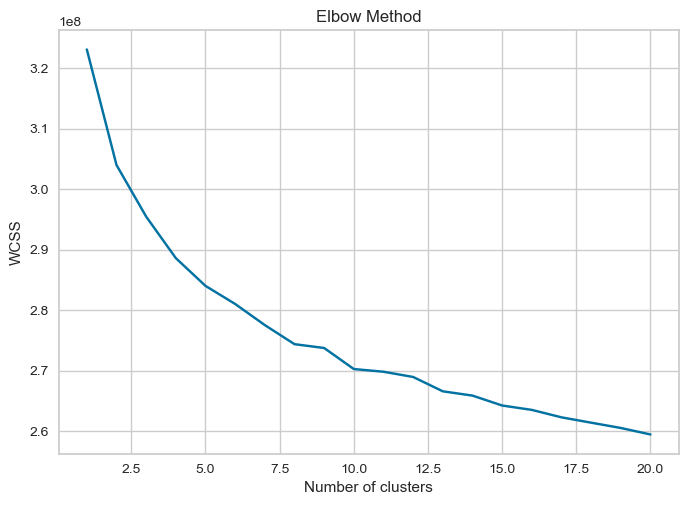

In [84]:
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

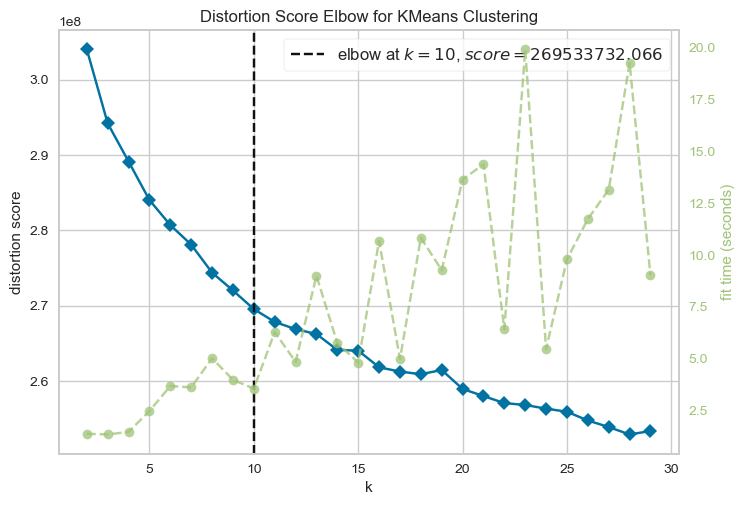

In [88]:
try:
    Elbow_M = KElbowVisualizer(KMeans(), k=(2,30))   #30 is the max expected number of clusters really
    Elbow_M.fit(df_pca)
    Elbow_M.show()
except Exception as e:
    print(f"An error occurred: {e}")

Having our number of clusters equalling `10` from KELbow, we can build our model

In [94]:
kmeans = KMeans(n_clusters=10, random_state=42) 

In [104]:
model = kmeans.fit(df_pca)

In [266]:
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

/var/folders/y1/2cln1s193dgc6xy3yzry761r0000gn/T/ipykernel_12687/3966728686.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')


In [268]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [270]:
np.setdiff1d(customer_list, general_list)

array(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], dtype='<U27')

We need to wrangle these dimensions here really

In [273]:
customers[['CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP']].isna().sum()

CUSTOMER_GROUP     0
ONLINE_PURCHASE    0
PRODUCT_GROUP      0
dtype: int64

In [275]:
customers[['CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CUSTOMER_GROUP   191652 non-null  object
 1   ONLINE_PURCHASE  191652 non-null  int64 
 2   PRODUCT_GROUP    191652 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.4+ MB


In [277]:
customers[['CUSTOMER_GROUP','PRODUCT_GROUP']]

,CUSTOMER_GROUP,PRODUCT_GROUP
0,MULTI_BUYER,COSMETIC_AND_FOOD
1,SINGLE_BUYER,FOOD
2,MULTI_BUYER,COSMETIC_AND_FOOD
3,MULTI_BUYER,COSMETIC
4,MULTI_BUYER,FOOD
...,...,...
191647,MULTI_BUYER,COSMETIC_AND_FOOD
191648,SINGLE_BUYER,COSMETIC
191649,MULTI_BUYER,COSMETIC_AND_FOOD
191650,SINGLE_BUYER,FOOD


In [281]:
customers['CUSTOMER_GROUP'].value_counts()

CUSTOMER_GROUP
MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: count, dtype: int64

In [279]:
customers['PRODUCT_GROUP'].value_counts()

PRODUCT_GROUP
COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: count, dtype: int64

In [299]:
product_dummies = pd.get_dummies(customers['PRODUCT_GROUP'], prefix='PRODUCT_GROUP')

KeyError: 'PRODUCT_GROUP'

In [285]:
product_dummies.head(1)

,PRODUCT_GROUP_COSMETIC,PRODUCT_GROUP_COSMETIC_AND_FOOD,PRODUCT_GROUP_FOOD
0,False,True,False


In [287]:
customers = customers.drop(columns=['PRODUCT_GROUP'])

In [289]:
customers['CUSTOMER_GROUP'].value_counts()

CUSTOMER_GROUP
MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: count, dtype: int64

In [291]:
customers['CUSTOMER_GROUP'] = customers['CUSTOMER_GROUP'].map({'MULTI_BUYER': 1, 'SINGLE_BUYER': 0})

In [293]:
customers[['CUSTOMER_GROUP','ONLINE_PURCHASE']].head()

,CUSTOMER_GROUP,ONLINE_PURCHASE
0,1,0
1,0,0
2,1,0
3,1,0
4,1,0


In [297]:
customers['CUSTOMER_GROUP'].value_counts()

CUSTOMER_GROUP
1    132238
0     59414
Name: count, dtype: int64

In [303]:
customers[['CUSTOMER_GROUP','ONLINE_PURCHASE']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   CUSTOMER_GROUP   191652 non-null  int64
 1   ONLINE_PURCHASE  191652 non-null  int64
dtypes: int64(2)
memory usage: 2.9 MB


In [305]:
cust = pd.concat([customers,product_dummies], axis=1)

In [315]:
customer_df = clean_data(cust)

In [321]:
customer_df.isna().sum().sum()

0

In [327]:
pca?

Type:        PCA
String form: PCA(n_components=215, random_state=42)
File:        ~/opt/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_pca.py
Docstring:  
Principal component analysis (PCA).

Linear dimensionality reduction using Singular Value Decomposition of the
data to project it to a lower dimensional space. The input data is centered
but not scaled for each feature before applying the SVD.

It uses the LAPACK implementation of the full SVD or a randomized truncated
SVD by the method of Halko et al. 2009, depending on the shape of the input
data and the number of components to extract.

With sparse inputs, the ARPACK implementation of the truncated SVD can be
used (i.e. through :func:`scipy.sparse.linalg.svds`). Alternatively, one
may consider :class:`TruncatedSVD` where the data are not centered.

Notice that this class only supports sparse inputs for some solvers such as
"arpack" and "covariance_eigh". See :class:`TruncatedSVD` for an
alternative with sparse data.

#### Imputer Operations

In [338]:
pd.DataFrame(scaler.transform(customer_df), columns=customer_df.columns)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- CUSTOMER_GROUP
- ONLINE_PURCHASE
- PRODUCT_GROUP_COSMETIC
- PRODUCT_GROUP_COSMETIC_AND_FOOD
- PRODUCT_GROUP_FOOD


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')